# Creating a mesh from the neural net model and point clouds

This notebook explores conversion methods from points clouds to meshes as well as from a neural network that ouputs density per point to mesh of the asteroid.

Please refer to the other notebooks for more details on the background. This one relies mostly on the First Improvements.ipynb

In [1]:
# core stuff
import h5py
import numpy as np
import scipy

# pytorch
from torch import nn
import torch
# For debugging and development purposes this is now set to float64 ... change for speed on GPUs
torch.set_default_tensor_type(torch.DoubleTensor)

#mesh related
import tetgen
import pyvista as pv
pv.set_plot_theme("night")

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

## Load the synthetic asteroid(s)

These are interesting clusters to study.

- sample_01 -> cluster_2400 (state 10567)
- sample_02 -> cluster_5486 (state_8741)
- sample_03 -> cluster_2284 (state_16698)
- sample_04 -> cluster_7315
- sample_05 -> cluster_3847
- sample_06 -> cluster_6137
- sample_07 -> cluster_2441
- sample_08 -> cluster_1970
- sample_09 -> cluster_1896

In [2]:
# We import the data from MPIA containing pseudo-stable asteroid shapes
sample = "sample_02"
f = h5py.File("sample_vis_data/" + sample + "/state_8741.hdf5",'r')
f2 = h5py.File('sample_vis_data/sample_02/global.hdf5', 'r')
cluster_name = 'cluster_5486'

In [3]:
# The file state_ ... contains the positions of all particles as well as the indices
# of those belonging to a cluster. Here we extract the largest ones.
dims = [(len(f[cluster][()]), cluster) for cluster in f.keys() if 'cluster' in cluster]
largest_clusters = sorted(dims,reverse=True)

In [4]:
# We have ordered the largest asteroids, we now extract positions for one in particular
rank = 1
#cluster_name = largest_clusters[rank][1]
# Or we directly name the one we want
print("Target: ", cluster_name)
# The particles idxs for this cluster
idx = f[cluster_name][()]
# The particle radius
radius = f2['radius'][()]
# Particle positions
x_raw = f['x'][()][idx]
y_raw = f['y'][()][idx]
z_raw = f['z'][()][idx]
print("Diameter: ", 2 * radius)

Target:  cluster_5486
Diameter:  0.00043088693800637674


## Create a point cloud for it

In [5]:
from sklearn.neighbors import NearestNeighbors
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x_raw, np.append(y_raw,z_raw))
point_cloud = point_cloud.reshape((3,len(x_raw)))
point_cloud = np.transpose(point_cloud)

nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(point_cloud)
distances, indices = nbrs.kneighbors(point_cloud)

print("Minimum distance between particles: ", min(distances[:,1]))
print("Maximum distance between particles: ", max(distances[:,1]))

# We take out particles that are not "touching" at least two neighbours
unstable_points = np.where(distances[:, 3]> 2 * radius * 1.1)[0]
print("Number of unstable points: ", len(unstable_points))
x = np.delete(x_raw, unstable_points, 0)
y = np.delete(y_raw, unstable_points, 0)
z = np.delete(z_raw, unstable_points, 0)


Minimum distance between particles:  0.00042332728057018366
Maximum distance between particles:  0.0005034108274804448
Number of unstable points:  5


In [6]:
# We subtract the mean so that the origin is the center of figure
x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.mean(z)
# We normalize so that the axes are at most one
max_value = max([max(abs(it)) for it in [x,y,z]])
x = x / max_value
y = y / max_value
z = z / max_value
plot_radius = radius /  max_value  * 3000
# We put xyz in a different shape (point_cloud)
point_cloud = np.append(x, np.append(y,z))
point_cloud = point_cloud.reshape((3,len(x)))
point_cloud = np.transpose(point_cloud)
point_cloud = torch.tensor(point_cloud)

<IPython.core.display.Javascript object>


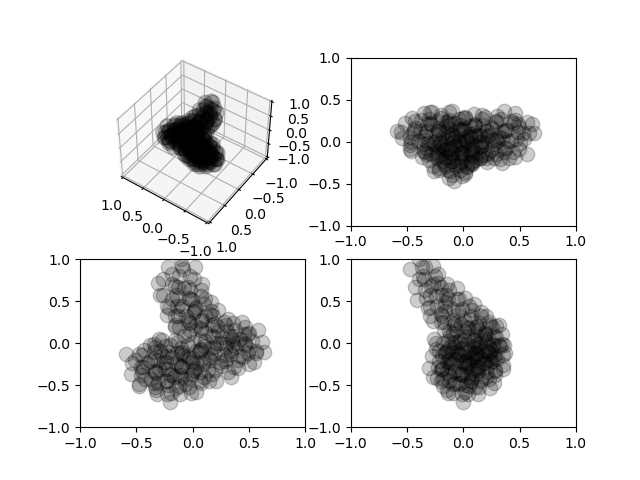

(-1.0, 1.0)

In [7]:
fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')

# And visualize the masses
ax.scatter(x, y, z, color = 'k', s = plot_radius/2, alpha=0.2)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(elev=45., azim=125.)

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, color = 'k', s = plot_radius/2, alpha=0.2)
ax2.set_xlim([-1,1])
ax2.set_ylim([-1,1])

ax3 = fig.add_subplot(223)
ax3.scatter(x, z, color = 'k', s = plot_radius/2, alpha=0.2)
ax3.set_xlim([-1,1])
ax3.set_ylim([-1,1])

ax4 = fig.add_subplot(224)
ax4.scatter(y, z, color = 'k', s = plot_radius/2, alpha=0.2)
ax4.set_xlim([-1,1])
ax4.set_ylim([-1,1])

## Convert to a mesh

The below algorithm creates a mesh for a point cloud by

1. Create a mesh for cube around the asteroid
2. Pull vertices some stepsize towards center unless the become too close to the point cloud
3. Repeat until no points move / max iterations reached

Iteration 0 - 6534 Travelling Vertices


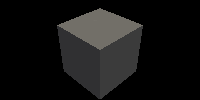

Iteration 50 - 6496 Travelling Vertices


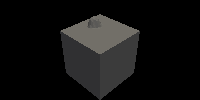

Iteration 100 - 5810 Travelling Vertices


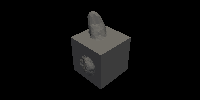

Iteration 150 - 1837 Travelling Vertices


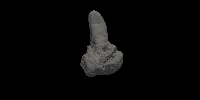

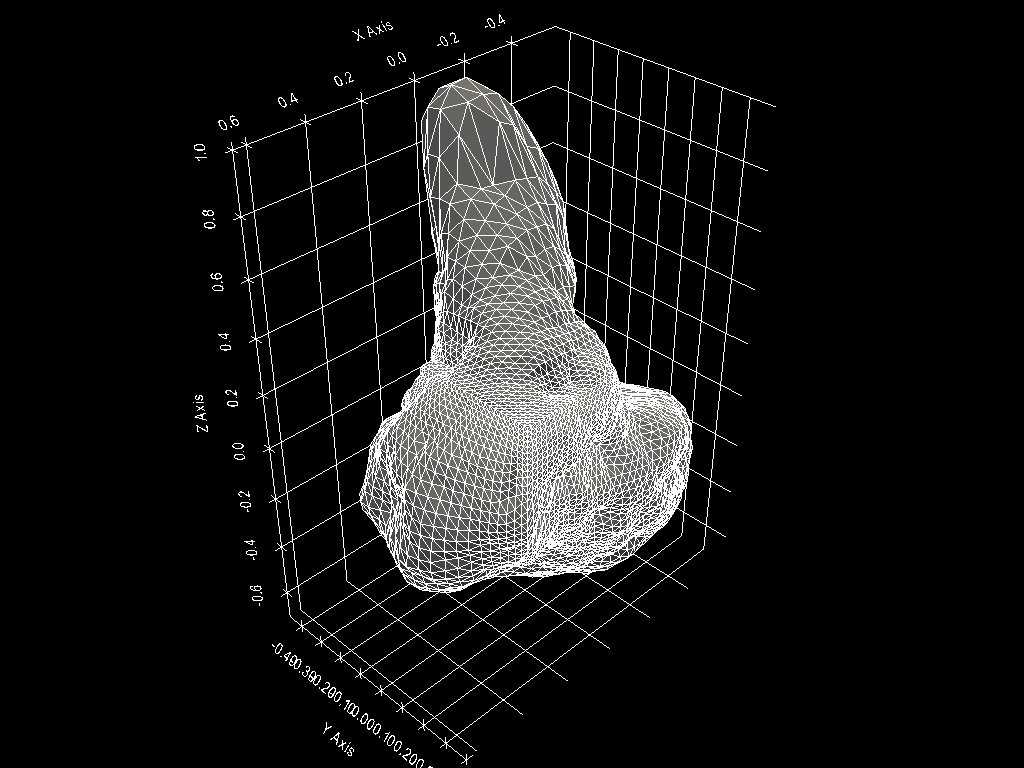

In [8]:
cloud = np.asarray([x,y,z]).transpose()

# This function computes the distance of some points `target_points`to the `cloud_points` per target point as
# min(distance(target_point,cloud_points))
def point_cloud_distance(target_points,cloud_points):
    distances = np.zeros(len(target_points))
    #per point compute distance to the cloud
    for i,point in enumerate(target_points):
        distances[i] = np.min(np.linalg.norm(point-cloud_points,axis=1))
    return distances

# This function computes the distance of some points `target_points`to the `cloud_points` per target point as
# mean distance of k closest cloud points
def point_cloud_topk_distance(target_points,cloud_points,k=5):
    distances = np.zeros(len(target_points))
    #per point compute distance to the cloud
    for i,point in enumerate(target_points):
        dist = np.linalg.norm(point-cloud_points,axis=1)
        #get 5 smallest elements and sum them
        idx = np.argpartition(dist, k)
        distances[i] = np.sum(dist[idx[:k]]) / k
    return distances

# Function to create mesh
def create_mesh_from_cloud(cloud_points, #point_cloud
                           cube_scale=1, #dimensions , 1 leads to [-1,1]^3
                           subdivisions = 5, #mesh granularity
                           stepsize = 0.005, #stepsize each vertix takes per iteration
                           target_point = [0,0,0], #point vertices "fly" towards
                           distance_threshold=0.125, #distance cutoff (0.125 good for 5point, 0.05 for 1point)
                           verbose = False,
                           plot_each_it = 50, #how often to plot
                           max_iter = 200):
    #Initialize cube mesh
    cube = pv.Cube(x_length=2*cube_scale,y_length=2*cube_scale,z_length=2*cube_scale).triangulate()
    cube = cube.subdivide(subdivisions)
    N = len(cube.points)
    
    #Initialize per vertex target direction (in which direction the vertex will travel)
    target_direction = target_point - cube.points
    
    if verbose: print(cube)
    
    #defines the still moving points
    point_to_compute = np.asarray([True] * N) 
    it = 0
        
    while any(point_to_compute) and it < max_iter:
        if it % plot_each_it == 0:
            print(f"Iteration {it} - {sum(point_to_compute)} Travelling Vertices")

        #Get remaining points
        remaining_points = cube.points[point_to_compute]
        if verbose: print("remaining_points",remaining_points)

        #Compute new position of each point
        new_points = remaining_points + stepsize * target_direction[point_to_compute]
        if verbose: print("new_points",new_points)

        #Compute values at new positions
        cloud_distances = point_cloud_topk_distance(new_points,cloud_points)
        if verbose: print("cloud_distances",cloud_distances)

        #Where value bigger than threshold stop changing this point
        point_to_compute[point_to_compute] = cloud_distances > distance_threshold
        if verbose: print("point_to_compute",point_to_compute)

        #Where value smaller than threshold change vertex to this position
        cube.points[point_to_compute] = new_points[cloud_distances > distance_threshold]
        if verbose: print("cube.points",cube.points)
        
        if it % plot_each_it == 0:
            p = pv.Plotter(window_size = [200,100])
            p.add_mesh(cube, color="grey", show_edges=False)
            p.show()
        
        it += 1
            
    #Plot mesh
    p = pv.Plotter()
    p.show_grid()
    p.add_mesh(cube, color="grey", show_edges=True)
    p.show(auto_close=True)

create_mesh_from_cloud(cloud) #test it

## Load the ANN Model from First Improvements.ipynb

In [9]:
# All encodings work taking as input a tensor (N, 3) containing the cartesian coordinates of N points
# and returning a tensor of (N, M) that can be used as input to the ANN

# Encoding N.1 (directional encoding):
# x = [x,y,z] is encoded as [ix, iy, iz, r]
class directional_encoding:
    def __init(self):
        self.n_inputs = 4
        self.name = "directional_encoding"
    # sp: sampled points
    def __call__(self, sp):
        unit = sp / torch.norm(sp,dim=1).view(-1,1)
        return torch.cat((unit, torch.norm(sp,dim=1).view(-1,1)), dim=1)

# Encoding N.2 (positional encoding):
# x = [x,y,z] is encoded as [sin(pi x), sin(pi y), sin(pi z), cos(pi x), cos(pi y), cos(pi z), sin(2 pi x), ....]
class positional_encoding:
    def __init__(self, N):
        self.n_inputs = 6 * N
        self.name = "positional_encoding_" + str(N)
    def __call__(self, sp):
        retval = torch.cat((torch.sin(np.pi * sp).view(-1,3),torch.cos(np.pi * sp).view(-1,3)), dim=1)
        for i in range(1, self.n_inputs // 6):
            retval = torch.cat((retval, torch.sin(2**i*np.pi * sp).view(-1,3),torch.cos(2**i*np.pi * sp).view(-1,3)), dim=1)
        return retval

# Encoding N.3 (direct encoding):
class direct_encoding:
    def __init__(self):
        self.n_inputs = 3
        self.name = "direct_encoding"
    def __call__(self, sp):
        return sp
        
# Encoding N.4 (spherical coordinates). These can be used with positional encoding to create effectively harmonics
class spherical_coordinates:
    def __init__(self):
        self.n_inputs = 3
        self.name = "spherical_coordinates"
    def __call__(self, sp):
        phi = torch.atan2(sp[:,1], sp[:,0]) / np.pi
        r = torch.norm(sp, dim=1)
        theta = torch.div(sp[:,2], r)
        return torch.cat((r.view(-1,1), phi.view(-1,1), theta.view(-1,1)), dim=1)

In [10]:
# Encoding choosen
encoding = direct_encoding()

# Network initialization scheme (note that if xavier uniform is used all outputs will start at, roughly 0.5)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.uniform_(m.bias.data, -0.0, 0.0)

# Network architecture. Note that the dimensionality of the first linear layer must match the output
# of the encoding chosen
n_neurons = 100
model = nn.Sequential(
          nn.Linear(encoding.n_inputs,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_  = model.apply(weights_init)

In [11]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
model.load_state_dict(torch.load("models/" + sample + "_" + cluster_name + "_" + encoding.name + ".mdl"))

<All keys matched successfully>

## Plot the network
The below algorithm creates a mesh from the network by

    1. Create a mesh for cube around the asteroid
    2. Pull vertices some stepsize towards center unless the density at the vertex is over some threshold
    3. Repeat until no points move / max iterations reached



Iteration 0 - 25350 Travelling Vertices


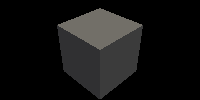

Iteration 200 - 25326 Travelling Vertices


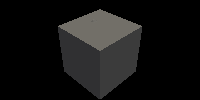

Iteration 400 - 25160 Travelling Vertices


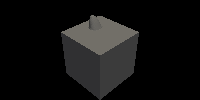

Iteration 600 - 22741 Travelling Vertices


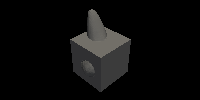

Iteration 800 - 3515 Travelling Vertices


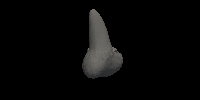

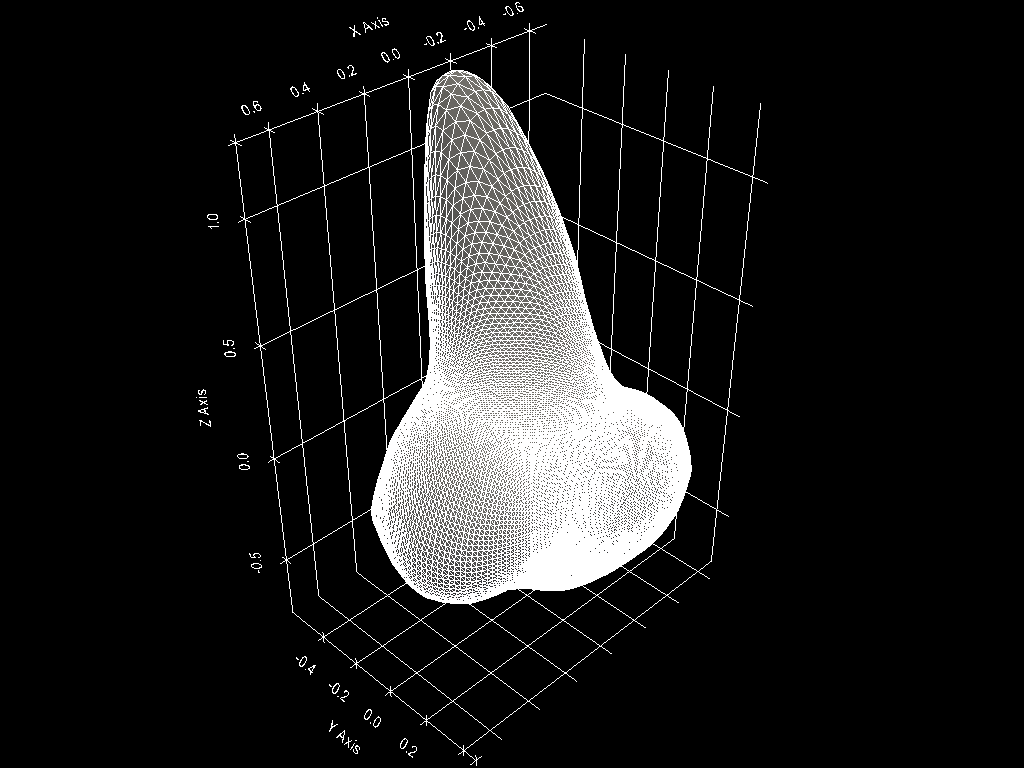

In [12]:
def create_mesh_from_model(model, #neural net
                           cube_scale=1.5,#cube dim 1 is [-1,1]^3
                           subdivisions = 6, #mesh subdivs
                           stepsize = 0.001, #stepsize of each vertix per iteration
                           target_point = [0,0,0], #target direction defined as target point per vertex
                           rho_threshold=3e-2, #density cutoff
                           verbose = False,
                           plot_each_it = 200, #how often to plot
                           max_iter = 10000):
    #Initialize cube mesh
    cube = pv.Cube(x_length=2*cube_scale,y_length=2*cube_scale,z_length=2*cube_scale).triangulate()
    cube = cube.subdivide(subdivisions)
    N = len(cube.points)
    
    #Initialize per vertex target direction (in which direction the vertex will travel)
    target_direction = target_point - cube.points
    
    if verbose: print(cube)
    
    #Will define which vertices are still traveling
    point_to_compute = np.asarray([True] * N)
    it = 0
        
    while any(point_to_compute) and it < max_iter:
        if it % plot_each_it == 0:
            print(f"Iteration {it} - {sum(point_to_compute)} Travelling Vertices")

        #Get remaining points
        remaining_points = cube.points[point_to_compute]
        if verbose: print("remaining_points",remaining_points)

        #Compute new position of each point
        new_points = remaining_points + stepsize * target_direction[point_to_compute]
        if verbose: print("new_points",new_points)

        #Compute values at new positions
        new_points = torch.tensor(new_points)
        nn_inputs = encoding(new_points)
        rho = model(nn_inputs).squeeze().detach().numpy()
        if verbose: print("rho",rho)

        #Where value bigger than threshold stop changing this point
        point_to_compute[point_to_compute] = rho < rho_threshold
        if verbose: print("point_to_compute",point_to_compute)

        #Where value smaller than threshold change vertex to this position
        cube.points[point_to_compute] = new_points[rho < rho_threshold]
        if verbose: print("cube.points",cube.points)
        
        if it % plot_each_it == 0:
            p = pv.Plotter(window_size = [200,100])
            p.add_mesh(cube, color="grey", show_edges=False)
            p.show()
        
        it += 1
            
    #Plot mesh
    p = pv.Plotter()
    p.show_grid()
    p.add_mesh(cube, color="grey", show_edges=True)
    p.show(auto_close=True)

create_mesh_from_model(model)